# Data Encoding

In this section, we will introduce the problem of data encoding for quantum machine learning, then describe and implement various data encoding methods. 

## Contents

1. [Introduction](#Introduction)
1. [Methods](#Methods)
  1. [Basis Encoding](#Basis-Encoding)
  1. [Amplitude Encoding](Amplitude-Encoding)
  1. [Angle Encoding](#Angle-Encoding)
1. [References](#References)

## Introduction

Data representation is crucial for the success of machine learning models. For classical machine learning, this question usually takes the form how to represent the data numerically, so that it can be best processed by a classical machine learning algorithm. For quantum machine learning, this question is similar, but more fundamental: how to represent and efficiently input the data into a quantum system, so that it can be processed by a quantum machine learning algorithm. This is usually referred to as data *encoding*, but is also called data *embedding* or *loading*. 

## Methods

Let's consider a classical dataset $\mathscr{X}$ consisting of $M$ samples, each with $N$ features: 
$$\mathscr{X} = \{x^{(1)},...,x^{(m)},...,x^{(M)}\}$$
where $x^{(m)}$ is an $N$ dimensional vector for $m = 1, ..., M$. To represent this dataset in a qubit system, we can use various embedding techniques, some of which are briefly explained and implemented below, as per References [1](#References) and  [2](#References).

### Basis Encoding

Basis encoding associates a classical $N$-bit string with a computational basis state of a $N$-qubit system. For example, if $x = 5$, this can be represented as a $4$-bit string as $0101$, and by a $4$-qubit system as the quantum state $|0101\rangle$. More generally, for a $N$-bit string: $x = (b_1, b_2, ... , b_N)$ and the corresponding $N$-qubit state is $| x \rangle = | b_1, b_2, ... , b_N \rangle$ with \$b_n \in \{0,1\}$ for $n = 1 , ...  , N$.

For the classical dataset $\mathscr{X}$ described above, to use basis encoding, each datapoint has to be a $N$-bit string: $x^{(m)} = (b_1, b_2, ... , b_N)$, which then can be mapped directly to the quantum state $|x^{m} \rangle = | b_1, b_2, ... , b_N \rangle$ with \$b_n \in \{0,1\}$ for $n = 1, ...,  N$ and $m = 1, ..., M$. The entire dataset can be represented in superpositions of computational basis states:
$$| \mathscr{X} \rangle = \frac{1}{\sqrt{M}}\sum_{m=1}^{M}|x^{m} \rangle $$

In qiskit, once we calculate what state will encode our dataset, we can use the `initialize` function to prepare it. For example, the dataset $\mathscr{X} = \{x^{(1)}=101, x^{(2)}=111\}$ is encoded as the state $|\mathscr{X}\rangle= \frac{1}{\sqrt{2}}(|101\rangle+|111\rangle)$:

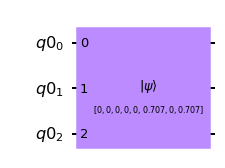

In [1]:
import math
from qiskit import QuantumCircuit, QuantumRegister

desired_state = [
    0,
    0,
    0,
    0,
    0,
    1 / math.sqrt(2),
    0,
    1 / math.sqrt(2)]

qr = QuantumRegister(3)
qc = QuantumCircuit(qr)
qc.initialize(desired_state, qr)
qc.draw(output='mpl')

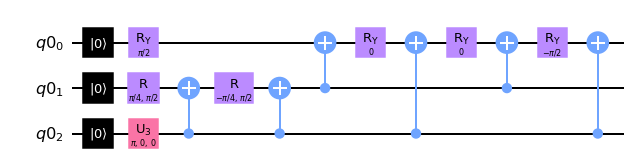

In [2]:
qc.decompose().decompose().decompose().decompose().decompose().draw(output='mpl')

This example illustrates a couple of disadvantages of basis encoding. While it is simple to understand, the state vectors can become quite sparse, and schemes to implement it are usually not efficient. 

### Amplitude Encoding

Amplitude encoding encodes data into the amplitudes of a quantum state. A normalised classical $N$-dimensional datapoint $x$ can be represented by the amplitudes of a $n$-qubit quantum state $|\psi_x\rangle$ as:
$$|\psi_x\rangle = \sum_{i=1}^N x_i |i\rangle$$
where $N = 2^n$, $x_i$ is the $i^{th}$ element of $x$ and $|i\rangle$ is the $i^{th}$ computational basis state. 

To encode the classical dataset $\mathscr{X}$ described above, we concatenate all $M$ $N$-dimensional datapoints into one amplitude vector, of length $N \times M$:
$$\alpha=A_{norm}(x_{1}^{(1)},...,x_{N}^{(1)},...,x_{1}^{(m)},...,x_{N}^{(m)},...,x_{1}^{(M)},...,x_{N}^{(M)})$$
where $A_{norm}$ is a normalisation constant, such that $|\alpha|^2 = 1$. The dataset $\mathscr{X}$ can now be represented in the computational basis as:
$$|\mathscr{X}\rangle = \sum_{i=1}^N \alpha_i |i\rangle$$
where $\alpha_i$ are elements of the amplitude vector and $|i\rangle$ are the computational basis states. The number of amplitudes to be encoded is $N \times M$.  As a system of $n$ qubits provides $2^n$ amplitudes, amplitude embedding requires $n \ge \mathrm{log}_2(NM)$ qubits.

As an example, let's encode the dataset $\mathscr{X}= \{x^{(1)}=(1.5,0), x^{(2)}=(-2,3)\}$ using amplitude encoding. Concatenating both data points and normalizing the resulting vector, we get:
$$\alpha = \frac{1}{\sqrt{15.25}}(1.5,0,-2,3)$$
and the resulting 2-qubit quantum state would be: 
$$|\mathscr{X}> = \frac{1}{\sqrt{15.25}}(1.5|00\rangle-2|10\rangle+3|11\rangle)$$

In the example above, the total number of elements of the amplitude vector, $N \times M$, is a power of 2. When $N \times M$ is not a power of 2, we can simply choose a value for $n$ such that $2^n\geq MN$ and pad the amplitude vector with uninformative constants.

Like in basis encoding, once we calculate what state will encode our dataset, in qiskit we can use the `initialize` function to prepare it:

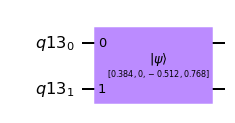

In [3]:
import math
from qiskit import QuantumCircuit, QuantumRegister

desired_state = [
    1 / math.sqrt(15.25) * 1.5,
    0,
    1 / math.sqrt(15.25) * -2,
    1 / math.sqrt(15.25) * 3]

qr = QuantumRegister(2)
qc = QuantumCircuit(qr)
qc.initialize(desired_state, qr)
qc.draw(output='mpl')

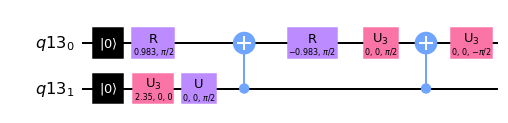

In [4]:
qc.decompose().decompose().decompose().decompose().decompose().draw(output='mpl')

The advantage of amplitude encoding is that it only requires $\mathrm{log}_2(NM)$ qubits to encode. However, subsequent algorithms must designed to operate on the amplitudes of a quantum state, and methods to prepare and measure the quantum states tend not to be efficient. 

### Angle Encoding

Angle encoding encodes $N$ features into the rotation angles of $n$ qubits, where $N \le n$. For example, the datapoint $x = (x_1,...,x_N)$ can be encoded as:
$$|x\rangle = \bigotimes_{i=1}^N \cos(x_i)|0\rangle + \sin(x_i)|1\rangle$$

This is different from the previous two encoding methods, as it only encodes one datapoint at a time, rather than a whole dataset. It does however, only use $N$ qubits and a constant depth quantum circuit, making it amenable to current quantum hardware. 

We can specify angle encoding as a unitary:
$$ S_{x_j} = \bigotimes_{i=1}^N U(x_j^{(i)}) \, 
\mathrm{where} \, 
U(x_j^{(i)}) = \begin{bmatrix} \cos(x_j^{(i)}) & -\sin(x_j^{(i)}) \\ \sin(x_j^{(i)}) & \cos(x_j^{(i)}) \\ \end{bmatrix}$$

Remembering that a single-qubit rotation around the $Y$-axis is: 
$$RY(\theta) = exp(-i \frac{\theta}{2} Y) = \begin{pmatrix} \cos{\frac{\theta}{2}} & -\sin{\frac{\theta}{2}} \\ \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}} \end{pmatrix} $$            
            
We note that $U(x_j^{(i)}) = RY(2x_j^{(i)})$, and as an example, encode the datapoint $x = (0, pi/4, pi/2)$ using qiskit:

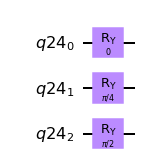

In [7]:
import math
from qiskit import QuantumCircuit, QuantumRegister

qr = QuantumRegister(3)
qc = QuantumCircuit(qr)

qc.ry(0,0)
qc.ry(math.pi/4,1)
qc.ry(math.pi/2,2)
qc.draw(output='mpl')

Dense angle encoding is a slight generalization of angle encoding, that encodes two features per qubit using the relative phase, where the datapoint $x = (x_1,...,x_N)$ can be encoded as:
$$|x\rangle = \bigotimes_{i=1}^{N/2} \cos(x_{2i-1})|0\rangle + e^{i x_{2i}}\sin(x_{2i-1})|1\rangle$$

Although the angle and dense angle encoding use sinuosoids and exponentials, there is nothing special about these functions, and we can easily abstract these to a general class of qubit encodings that use arbitrary functions, or define the encodings as arbitrary unitaries, implemented as parameterized quantum circuits.

## References

1.  Maria Schuld and Francesco Petruccione, *Supervised Learning with Quantum Computers*, Springer 2018, [doi:10.1007/978-3-319-96424-9](https://www.springer.com/gp/book/9783319964232).
2. Ryan LaRose and Brian Coyle, *Robust data encodings for quantum classifiers*, Physical Review A 102, 032420 (2020), [doi:10.1103/PhysRevA.102.032420](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.032420), [arXiv:2003.01695](https://arxiv.org/abs/2003.01695).

In [6]:
import qiskit.tools.jupyter
%qiskit_version_table